## 3rd Day: Application
### SVM

### Data Description (PSID Data):
1. 4722 parent-child pairs in Panel Study of Income Dynamics (PSID)
2. Birth cohorts: 1967 ~ 1977
3. Child must be aged between 0 and 35 during the years 1967-2020
4. All incomes refer to household income: sum of taxable incomes of the individual and spouse
5. Parental income: average income during ages 31 to 60 (must have 18 incomes)
6. Income deflated by Consumer Price Index for All Urban Consumers (CPI-U-RS, 1977 = 100)
7. Income is top-coded in PSID; zero or negative income bottom coded to one

### Data used in the binary choice model
1. $Y$: Binary variable indicating a child's decision to go to college.
2. $X$: A set of covariates including
    1. Parental income
    2. The average of mother's and father's age at birth
    3. Whether the parent has college education -> either father or mother
    4. Gender
    5. Whether the child is black
    6. Whether the child has been born underweight
    8. Information for mother (at birth).
        1. Married
        2. Never married
        3. Widowed
        4. Divorced
        5. Separated
        
Data on 'Information for mother (at birth)' has been made into 4 dummy variable with the 'Married' category as the base. We have a total of 2 continuous variables and 8 dummy variables.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import time
import datetime
import plotly.graph_objects as go
from scipy.optimize import bisect
from matplotlib import colors

seed = 42
np.random.seed(seed) # For shuffling X_used and Y

PSID = pd.read_csv('Data/PSID_extended.csv')
PSID.columns
Y = PSID.edu_college
X = PSID.drop(['edu_college'],axis=1)
child_hh_inc = X[['hh_inc_at_%i'% i for i in range(30,36)]]
idx = np.sum(np.isnan(child_hh_inc),1)<4

X_used = X[idx].reset_index(drop=True)
Y_used = Y[idx].reset_index(drop=True)
X_used = X_used.drop(columns=['hh_inc_at_%i'% i for i in range(30,36)])

idx = np.random.permutation(X_used.index) # Shuffle rows of X_used and Y in the same way in case rows are ordered in a specific way
X_used = X_used.reindex(idx).reset_index(drop=True)
Y_used = Y_used.reindex(idx).reset_index(drop=True)

idx = X_used.birth_age < 11 # Drop rows with average of mother and father's age at birth less than 11
X_used= X_used[~idx].reset_index(drop=True)
Y_used= Y_used[~idx].reset_index(drop=True)

X_used = pd.concat((X_used,pd.get_dummies(X_used.mother_marital_at_birth).astype(int)),axis=1)
X_used = X_used.drop(columns='mother_marital_at_birth')
X_used = X_used.rename(columns={1:'married',2:'never_married',3:'widowed',4:'divorced',5:'separated'})
X_used = X_used.drop(columns='married')

X_used = X_used[['prt_inc', 'birth_age', 'parent_edu_college', 'person_sex', 'black', 
 'birth_underweight', 'never_married', 'widowed', 'divorced', 'separated']] # Reorder columns

gender = X_used.person_sex.replace({1:0, 0:1})
X_used.loc[:,'person_sex'] = gender  # We set male=0, female=1

outlier_idx = X_used.prt_inc>600000
X_used = X_used.drop(np.where(outlier_idx)[0]).reset_index(drop=True)
Y_used = Y_used.drop(np.where(outlier_idx)[0]).reset_index(drop=True)
n = X_used.shape[0]

X_used_stzd = (X_used - np.mean(X_used, axis=0))/np.std(X_used, axis = 0)

print('Ratio of children going to college is %f'%(np.sum(Y_used)/Y_used.shape[0]))

Ratio of children going to college is 0.350561


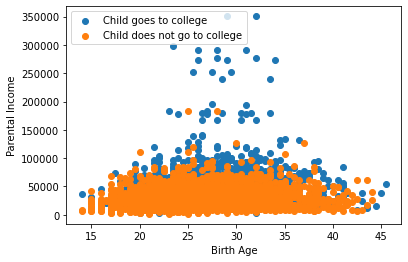

In [7]:
plt.scatter(X_used.birth_age[Y_used==1],X_used.prt_inc[Y_used==1],label="Child goes to college")
plt.scatter(X_used.birth_age[Y_used==0],X_used.prt_inc[Y_used==0],label="Child does not go to college")
plt.xlabel("Birth Age")
plt.ylabel("Parental Income")
plt.legend()
# plt.savefig('Figures/data.png')
# plt.show()

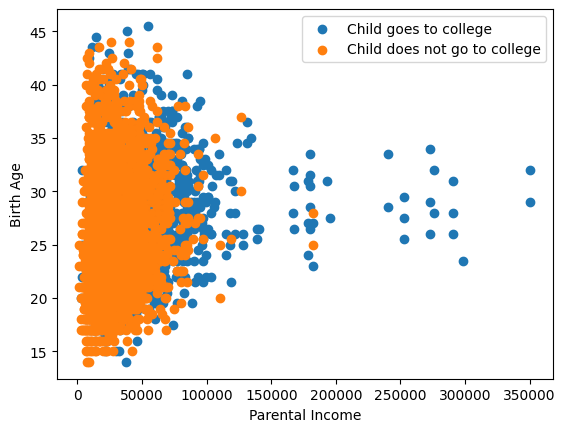

In [3]:
plt.scatter(X_used.prt_inc[Y_used==1],X_used.birth_age[Y_used==1],label="Child goes to college")
plt.scatter(X_used.prt_inc[Y_used==0],X_used.birth_age[Y_used==0],label="Child does not go to college")
plt.ylabel("Birth Age")
plt.xlabel("Parental Income")
plt.legend()
# plt.savefig('Figures/data.png')
# plt.show()

Logit model is defined by the following expression
\begin{align*}
    Y^* &= X'\beta + u\\
    Y &= \begin{cases}
        1 & \text{if } Y^*>0\\
        0 & \text{otherwise}
    \end{cases}
\end{align*}
where CDF of $u$ is given by logit function, i.e., $\mathbb{P}\{u\leq z\} = \frac{1}{1+e^{-z}}$. We may call the function $f(x) = x'\beta$ decision function and the set $\{x: f(x) = 0\}$ the decision boundary. We penalize the negative log likelihood function by the l2 norm of $\beta$ for regularization.

By coding $Y$ as 
\begin{align*}
    Y &= \begin{cases}
        1 & \text{if } Y^*>0\\
        -1 & \text{otherwise}
    \end{cases}
\end{align*}
Minimizing the penalized negative log likelihood can be written as
\begin{align*}
    \min_{\beta,\beta_0} \sum_{i=1}^n \log(1+e^{-y_i(\beta_0 + \beta' x_i)}) + \lambda \|\beta\|^2
\end{align*}

elapsed time = 3.31 sec; 2024-08-21 13:52:41.695597


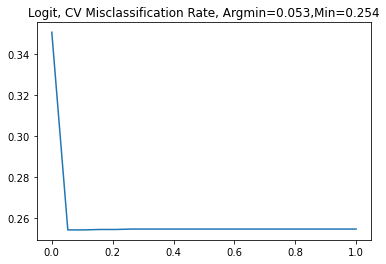

In [8]:
############################################################################
###########################   Logit Model   ################################
############################################################################
# Perform cross validation to select the tuning parameter C
C_list = np.linspace(0.0000000001,1,20)    #a larger c makes we choose a lower penalty, a small c makes us choose a higher penalty
Kfold = 5
divide_idx = [int(i) for i in np.linspace(0,n,Kfold+1)]
CV_error_logit = np.zeros((len(C_list), Kfold))
t = time.time()
for j,C in enumerate(C_list):
    for i in range(Kfold):
        X_test = X_used_stzd.iloc[divide_idx[i]:divide_idx[i+1]]
        Y_test = Y_used.iloc[divide_idx[i]:divide_idx[i+1]]

        X_train = X_used_stzd.drop(index=X_used_stzd.iloc[divide_idx[i]:divide_idx[i+1]].index,axis=0)
        Y_train = Y_used.drop(index=Y.iloc[divide_idx[i]:divide_idx[i+1]].index,axis=0)    

        clf = LogisticRegression(C=C).fit(X_train,Y_train)
        Y_hat = clf.predict(X_test)
        
        CV_error_logit[j, i] = np.mean(Y_test.values!=Y_hat)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))
plt.plot(C_list, np.mean(CV_error_logit,1))
plt.title('Logit, CV Misclassification Rate, Argmin=%0.3f,Min=%0.3f'%(C_list[np.mean(CV_error_logit,1).argmin()],np.min(np.mean(CV_error_logit,1))))
plt.show()
# plt.savefig('Figures/Cross_validation_Logit.png')
# plt.close()
Logit_model = LogisticRegression(C=C_list[np.mean(CV_error_logit,1).argmin()]).fit(X_used_stzd,Y_used)


Linear SVM is given by the solution to the following problem:
\begin{align*}
    \min_{\beta,\beta_0} \sum_{i=1}^n[1-y_i(x_i'\beta +\beta_0)]_{+} + \frac{1}{2C}\|\beta\|^2
\end{align*}
where $[1-y_i(x_i'\beta +\beta_0)]_{+} = \max\{0,1-y_i(x_i'\beta +\beta_0)\}$ is called hinge loss function. Again, we may call the function $f(x) = x'\beta$ decision function and the set $\{x: f(x) = 0\}$ the decision boundary.

In [9]:
############################################################################
########################   Linear SVM Model   ##############################
############################################################################

# Perform cross validation to select the tuning parameter C
Kfold = 5
divide_idx = [int(i) for i in np.linspace(0,n,Kfold+1)]
CV_error_LSVM = np.zeros((len(C_list), Kfold))
t = time.time()
for j,C in enumerate(C_list):
    for i in range(Kfold):
        X_test = X_used_stzd.iloc[divide_idx[i]:divide_idx[i+1]]
        Y_test = Y_used.iloc[divide_idx[i]:divide_idx[i+1]]

        X_train = X_used_stzd.drop(index=X_used_stzd.iloc[divide_idx[i]:divide_idx[i+1]].index,axis=0)
        Y_train = Y_used.drop(index=Y.iloc[divide_idx[i]:divide_idx[i+1]].index,axis=0)    
       
        clf = LinearSVC(C=C, dual='auto').fit(X_train,Y_train)
        Y_hat = clf.predict(X_test)
        
        CV_error_LSVM[j, i] = np.mean(Y_test.values!=Y_hat)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

plt.plot(C_list, np.mean(CV_error_LSVM,1))
plt.title('LSVM, CV Misclassification Rate, Argmin=%0.3f,Min=%0.3f'%(C_list[np.mean(CV_error_LSVM,1).argmin()],np.min(np.mean(CV_error_LSVM,1))))
# plt.savefig('Figures/Cross_validation_LSVM.png')
# plt.close()
plt.show()

LSVM_model = LinearSVC(C=C_list[np.mean(CV_error_LSVM,1).argmin()], dual='auto').fit(X_used_stzd,Y_used)

ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='squared_hinge' are not supported when dual=auto, Parameters: penalty='l2', loss='squared_hinge', dual='auto'

In [6]:
logit_coef = pd.DataFrame(np.concatenate((Logit_model.intercept_,Logit_model.coef_[0]),axis=0))
LSVM_coef = pd.DataFrame(np.concatenate((LSVM_model.intercept_,LSVM_model.coef_[0]),axis=0))
coefs = pd.concat((logit_coef,LSVM_coef),axis=1)
coefs
coefs.index = np.append(['constant'],list(X_used_stzd.columns))
coefs.columns = ['Logit Estimates','LSVM Estimates']
display(coefs)

,Logit Estimates,LSVM Estimates
constant,-0.686060,-0.290062
prt_inc,0.693798,0.267815
birth_age,0.080769,0.029113
parent_edu_college,0.563806,0.260439
person_sex,0.132289,0.048752
black,-0.143679,-0.048509
birth_underweight,-0.004606,-0.001469
never_married,0.040149,0.015837
widowed,-0.032107,-0.008525
divorced,-0.033729,-0.009635


Since the coefficients on 'Parental income' and 'Age' are both positive for Logit and LSVM, the models will tend to predict on the child going to college as the 'Parental income' and 'Age' increases.

## SVM
The dual problem of SVM is written as
\begin{align*}
    \max_{0\leq\alpha \leq C}g(\alpha)\{ = \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{k=1}^n\alpha_i\alpha_ky_iy_kK(x_i,x_k)\}\quad \text{s.t. } \sum_{i=1}^n\alpha_iy_i = 0
\end{align*}
and the decision function is given as the sum of kernel functions
\begin{align*}
f(x) = \beta_0 + \sum_{j=1}^n\alpha_jK(x,x_j)
\end{align*}

elapsed time = 27.59 sec; 2024-08-21 12:36:19.816992


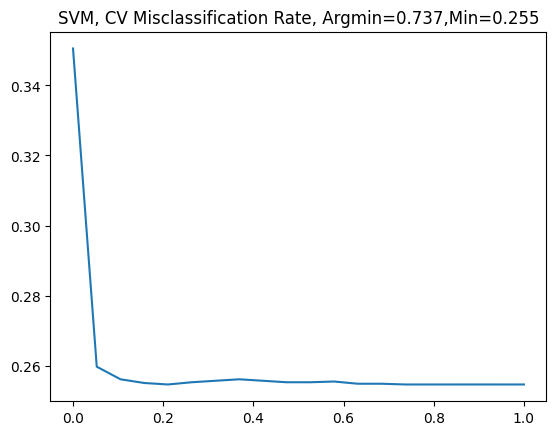

In [7]:
############################################################################
############################  SVM Model   ##################################
############################################################################

# Perform cross validation to select the tuning parameter C
C_list = np.linspace(0.0000000001,1,20)
Kfold = 5
divide_idx = [int(i) for i in np.linspace(0,n,Kfold+1)]
CV_error_SVM = np.zeros((len(C_list), Kfold))
gamma = 1/X_used_stzd.shape[1]
t = time.time()
for j,C in enumerate(C_list):
    for i in range(Kfold):
        X_test = X_used_stzd.iloc[divide_idx[i]:divide_idx[i+1]]
        Y_test = Y_used.iloc[divide_idx[i]:divide_idx[i+1]]

        X_train = X_used_stzd.drop(index=X_used_stzd.iloc[divide_idx[i]:divide_idx[i+1]].index,axis=0)
        Y_train = Y_used.drop(index=Y.iloc[divide_idx[i]:divide_idx[i+1]].index,axis=0)    
        
        clf = SVC(kernel='rbf', gamma=gamma, C=C).fit(X_train,Y_train)
        Y_hat = clf.predict(X_test)
        
        CV_error_SVM[j, i] = np.mean(Y_test.values!=Y_hat)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

plt.plot(C_list, np.mean(CV_error_SVM,1))
plt.title('SVM, CV Misclassification Rate, Argmin=%0.3f,Min=%0.3f'%(C_list[np.mean(CV_error_SVM,1).argmin()],np.min(np.mean(CV_error_SVM,1))))
# plt.savefig('Figures/Cross_validation_SVM.png')
# plt.close()
plt.show()

By default, we'll study the SVM with the BoxConstraint parameter (C) chosen at CE error minimizer and kernel bandwidth (gamma) parameter chosen at 1/(# of covariates). To investigate how increasing/decreasing C or gamma will change the separating hyperplane, we may try other values by changing the code block below.

In [8]:
SVM_model = SVC(kernel='rbf', gamma=gamma, C=C_list[np.mean(CV_error_SVM,1).argmin()]).fit(X_used_stzd,Y_used)
# SVM_model = SVC(kernel='rbf', gamma=gamma, C=10).fit(X_used_stzd,Y_used)
# SVM_model = SVC(kernel='rbf', gamma=gamma*10, C=C_list[np.mean(CV_error_SVM,1).argmin()]).fit(X_used_stzd,Y_used)

## Investigating The Estimated Separating Hyperplane (Decision Boundary) of Logit, LSVM and SVM

Since both logit model and linear SVM has linear decision function, we may find explicit form of the decision boundary (or separating hyperplane). To do this, we find a set of values $x\in\mathbb{R}^m$ such that $\hat f(x) = 0$. To plot the decision boundary in a grid, let $x = (v,w)$ where $v$ collects the two continuous variables and $w$ collects the 8 dummy variables. The baseline group in our sample will be given by those with $w=\bar{w}$ where $\bar{w}$ denotes the dummies evaluated at
1. Parents have no college education
2. Male
3. Child is not black
4. Child is not born underweight
5. Mother married at birth

With $w$ given at $\bar{w}$, we find and graph the set $$ \{v\in\mathbb{R}^2: \hat f(v,\bar{w})=0\}$$. For the logit and LSVM, the decision function is linear, i.e., $f(x) = x'\beta$, and we have
$$ \{v\in\mathbb{R}^2: v'\hat{\beta}_1 + \bar{w}'\hat{\beta}_2=0\}$$
However, in the SVM, the desicion function is nonlinear. Thus, given $w=\bar{w}$, we numerically find the set $$ \{v\in\mathbb{R}^2: \hat f(v,\bar{w})=0\}$$ using nonlinear optimization methods. We use bisection method to find the root of the function $\hat f(v,\bar{w})$.

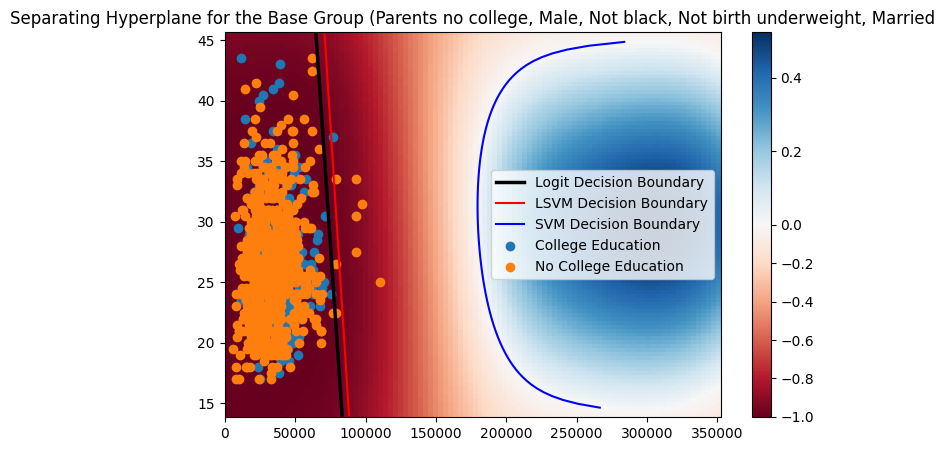

In [9]:
X_used_stzd_min = np.min(X_used_stzd,0)
X_used_stzd_max = np.max(X_used_stzd,0)
X_used_std = np.std(X_used, axis = 0)
X_used_mean = np.mean(X_used, axis=0)
dummies_stzd = pd.concat((X_used_stzd_min,X_used_stzd_max),axis=1)
grid_n = 100
birth_age_grid = np.linspace(X_used_stzd_min.birth_age,X_used_stzd_max.birth_age,grid_n)
prt_inc_grid = np.linspace(X_used_stzd_min.prt_inc,X_used_stzd_max.prt_inc,grid_n)

group_id = {'parent_edu_college':0, 'person_sex':0, 'black':0, 'birth_underweight':0,
           'never_married':0, 'widowed':0, 'divorced':0, 'separated':0}
group_val = {}

for key, value in group_id.items():
    group_val[key] = dummies_stzd.loc[key][value]

prt_inc_grid_logit = (-Logit_model.intercept_[0]-Logit_model.coef_[0][1]*birth_age_grid
                      -Logit_model.coef_[0][2:] @ np.array(list(group_val.values())))/Logit_model.coef_[0][0]
prt_inc_grid_LSVM = (-LSVM_model.intercept_[0]-LSVM_model.coef_[0][1]*birth_age_grid
                      -LSVM_model.coef_[0][2:] @ np.array(list(group_val.values())))/LSVM_model.coef_[0][0]

root = np.zeros((len(birth_age_grid),))
err = np.zeros((len(birth_age_grid),))
for i, ba in enumerate(birth_age_grid):
    X_temp = pd.Series(group_val)
    X_temp = pd.DataFrame(X_temp).T
    X_temp.insert(0, 'birth_age', ba)
    X_temp.insert(0, 'prt_inc', X_used_stzd_min.prt_inc)
    def myFun(x,X_temp,SVM_model):
        X_temp['prt_inc']=x
        val = SVM_model.decision_function(X_temp)
        return val[0]
    f = lambda x: myFun(x,X_temp,SVM_model)
    start_idx=np.argmin([f(pi) for pi in prt_inc_grid])
    end_idx=np.argmax([f(pi) for pi in prt_inc_grid])
    try:
        root[i] = bisect(f, prt_inc_grid[start_idx], prt_inc_grid[end_idx])
        err[i] = f(root[i])
    except:
        root[i] = np.nan
        err[i] = 99

query = ""
for key, value in group_id.items():
    query = query + key + '==' + str(value) +' and '
query = query[:-5]

X_temp = X_used.query(query)
Y_temp_used = Y_used[X_temp.index]


grid_n = prt_inc_grid.shape[0]
xx11, xx22 = np.meshgrid(birth_age_grid, prt_inc_grid)

X_grid = np.concatenate([xx22.ravel().reshape(-1,1),                                                        # Parental Income grid
                         xx11.ravel().reshape(-1,1),                                                        # Birth age grid
                         (np.array(list(group_val.values()))*np.ones((grid_n**2,1)))], axis=1)            # not separated

X_grid = pd.DataFrame(X_grid)
X_grid.columns = X_used.columns
f_hat_vec = SVM_model.decision_function(X_grid)
f_hat_grid = f_hat_vec.reshape(grid_n,grid_n)

fig, ax = plt.subplots(1, 1,figsize=(8,5))
ax.plot(prt_inc_grid_logit*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='black',label='Logit Decision Boundary')
ax.plot(prt_inc_grid_LSVM*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=1.5,color='red',label='LSVM Decision Boundary')
ax.plot(root*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=1.5,color='blue',label='SVM Decision Boundary')
ylim_=ax.get_ylim()
xlim_=ax.get_xlim()
norm = colors.TwoSlopeNorm(vcenter=0,vmin=f_hat_grid.min(),  vmax=f_hat_grid.max())
c = ax.pcolormesh(prt_inc_grid*X_used_std.prt_inc+X_used_mean.prt_inc,
                   birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age, f_hat_grid.T, cmap='RdBu',norm=norm)
# ax.set_ylim(ylim_)
# ax.set_xlim((0,xlim_[1]))
ax.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
ax.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.title('Separating Hyperplane for the Base Group (Parents no college, Male, Not black, Not birth underweight, Married')
plt.colorbar(c)
plt.legend()
plt.show()

The coefficients on the decision function of the Logit and LSVM model tells us that the model will tend to predict on the child going to college as we move to the upper left of the above figure. Since we may not make such an argument for (kernel) SVM, we draw a heatmap representing the values of the decision function of the SVM model on the figure above.

##### Now, we study the effect of (1) parents having college education, (2) child being black, (3) child being female.

In [10]:
##################################################################
##### Effect of parents having college eduation #################
##################################################################
group_id_1 = {'parent_edu_college':1, 'person_sex':0, 'black':0, 'birth_underweight':0,
           'never_married':0, 'widowed':0, 'divorced':0, 'separated':0}
group_id_0 = {'parent_edu_college':0, 'person_sex':0, 'black':0, 'birth_underweight':0,
           'never_married':0, 'widowed':0, 'divorced':0, 'separated':0}
group_val_1 = {}
group_val_0 = {}

for key, value in group_id_1.items():
    group_val_1[key] = dummies_stzd.loc[key][value]

for key, value in group_id_0.items():
    group_val_0[key] = dummies_stzd.loc[key][value]

prt_inc_grid_logit_1 = (-Logit_model.intercept_[0]-Logit_model.coef_[0][1]*birth_age_grid
                      -Logit_model.coef_[0][2:] @ np.array(list(group_val_1.values())))/Logit_model.coef_[0][0]
prt_inc_grid_logit_0 = (-Logit_model.intercept_[0]-Logit_model.coef_[0][1]*birth_age_grid
                      -Logit_model.coef_[0][2:] @ np.array(list(group_val_0.values())))/Logit_model.coef_[0][0]

prt_inc_grid_LSVM_1 = (-LSVM_model.intercept_[0]-LSVM_model.coef_[0][1]*birth_age_grid
                      -LSVM_model.coef_[0][2:] @ np.array(list(group_val_1.values())))/LSVM_model.coef_[0][0]
prt_inc_grid_LSVM_0 = (-LSVM_model.intercept_[0]-LSVM_model.coef_[0][1]*birth_age_grid
                      -LSVM_model.coef_[0][2:] @ np.array(list(group_val_0.values())))/LSVM_model.coef_[0][0]

grid_n = prt_inc_grid.shape[0]
xx11, xx22 = np.meshgrid(birth_age_grid, prt_inc_grid)

X_grid_1 = np.concatenate([xx22.ravel().reshape(-1,1),                                                        # Parental Income grid
                         xx11.ravel().reshape(-1,1),                                                        # Birth age grid
                         (np.array(list(group_val_1.values()))*np.ones((grid_n**2,1)))], axis=1)            # not separated
X_grid_0 = np.concatenate([xx22.ravel().reshape(-1,1),                                                        # Parental Income grid
                         xx11.ravel().reshape(-1,1),                                                        # Birth age grid
                         (np.array(list(group_val_0.values()))*np.ones((grid_n**2,1)))], axis=1)            # not separated

X_grid_1 = pd.DataFrame(X_grid_1)
X_grid_1.columns = X_used.columns
f_hat_vec_1 = SVM_model.decision_function(X_grid_1)
f_hat_grid_1 = f_hat_vec_1.reshape(grid_n,grid_n)

X_grid_0 = pd.DataFrame(X_grid_0)
X_grid_0.columns = X_used.columns
f_hat_vec_0 = SVM_model.decision_function(X_grid_0)
f_hat_grid_0 = f_hat_vec_0.reshape(grid_n,grid_n)

query = ""
for key, value in group_id_1.items():
    if value == group_id_0[key]:
        query = query + key + '==' + str(value) +' and '
query = query[:-5]
X_temp = X_used.query(query)
Y_temp_used = Y_used[X_temp.index]

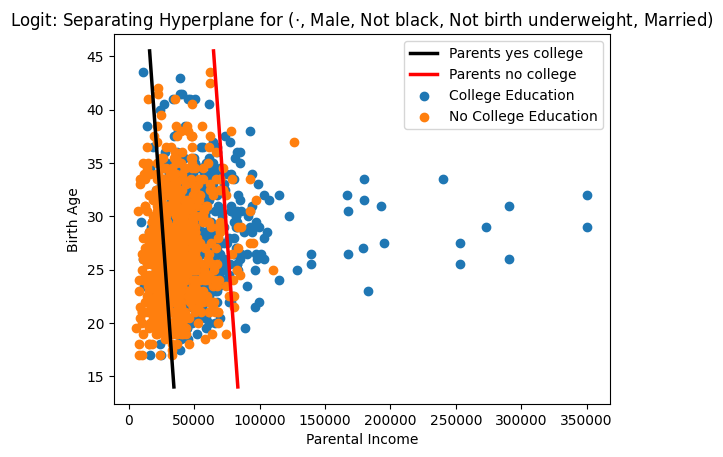

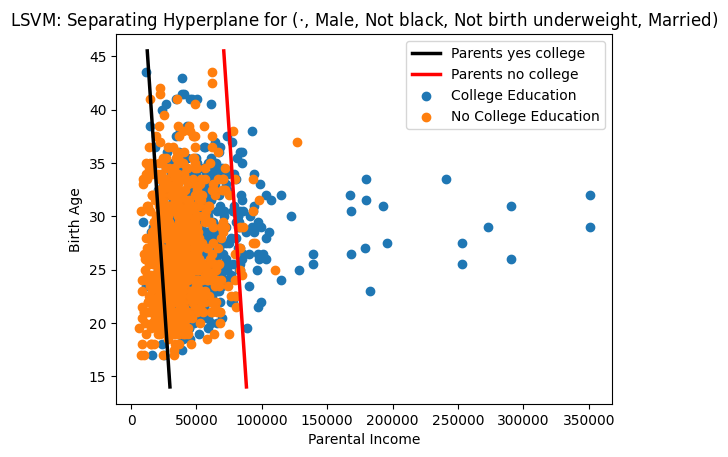

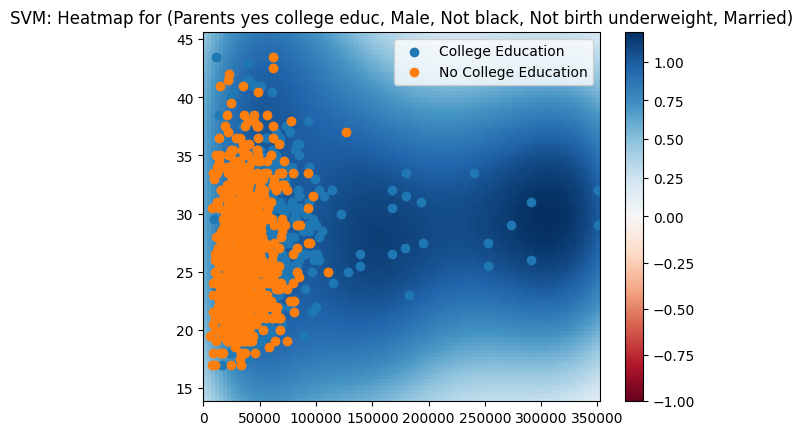

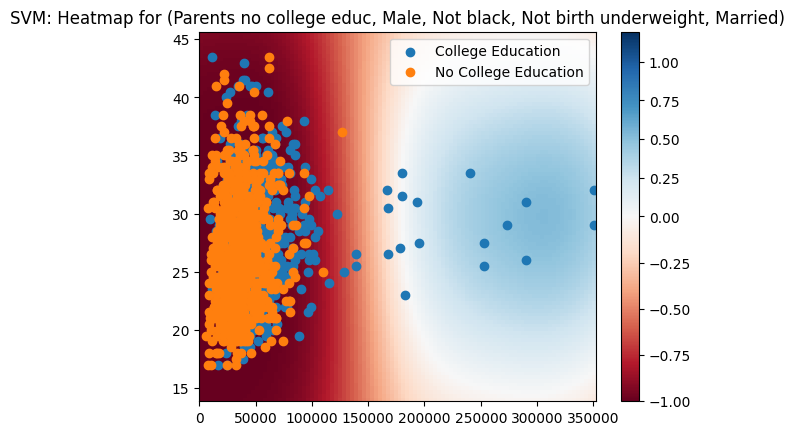

In [11]:

plt.plot(prt_inc_grid_logit_1*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='black',label='Parents yes college')
plt.plot(prt_inc_grid_logit_0*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='red',label='Parents no college')
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.legend()
plt.title('Logit: Separating Hyperplane for ($\cdot$, Male, Not black, Not birth underweight, Married)')
plt.ylabel('Birth Age')
plt.xlabel('Parental Income')
plt.show()

plt.plot(prt_inc_grid_LSVM_1*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='black',label='Parents yes college')
plt.plot(prt_inc_grid_LSVM_0*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='red',label='Parents no college')
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.legend()
plt.title('LSVM: Separating Hyperplane for ($\cdot$, Male, Not black, Not birth underweight, Married)')
plt.ylabel('Birth Age')
plt.xlabel('Parental Income')
plt.show()

norm = colors.TwoSlopeNorm(vcenter=0,vmin=np.min((f_hat_grid_0,f_hat_grid_1)),  vmax=np.max((f_hat_grid_0,f_hat_grid_1)))
c = plt.pcolormesh(prt_inc_grid*X_used_std.prt_inc+X_used_mean.prt_inc,
                   birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,f_hat_grid_1.T, cmap='RdBu',norm=norm)
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.colorbar(c)
plt.legend()
plt.title('SVM: Heatmap for (Parents yes college educ, Male, Not black, Not birth underweight, Married)')
plt.show()

norm = colors.TwoSlopeNorm(vcenter=0,vmin=np.min((f_hat_grid_0,f_hat_grid_1)),  vmax=np.max((f_hat_grid_0,f_hat_grid_1)))
c = plt.pcolormesh(prt_inc_grid*X_used_std.prt_inc+X_used_mean.prt_inc,
                   birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,f_hat_grid_0.T, cmap='RdBu',norm=norm)
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.title('SVM: Heatmap for (Parents no college educ, Male, Not black, Not birth underweight, Married)')
plt.colorbar(c)
plt.legend()
plt.show()

In [12]:
#################################
##### Effect of being black #####
#################################
group_id_1 = {'parent_edu_college':0, 'person_sex':0, 'black':1, 'birth_underweight':0,
           'never_married':0, 'widowed':0, 'divorced':0, 'separated':0}
group_val_1 = {}

group_id_0 = {'parent_edu_college':0, 'person_sex':0, 'black':0, 'birth_underweight':0,
           'never_married':0, 'widowed':0, 'divorced':0, 'separated':0}
group_val_0 = {}

for key, value in group_id_1.items():
    group_val_1[key] = dummies_stzd.loc[key][value]

for key, value in group_id_0.items():
    group_val_0[key] = dummies_stzd.loc[key][value]

prt_inc_grid_logit_1 = (-Logit_model.intercept_[0]-Logit_model.coef_[0][1]*birth_age_grid
                      -Logit_model.coef_[0][2:] @ np.array(list(group_val_1.values())))/Logit_model.coef_[0][0]
prt_inc_grid_logit_0 = (-Logit_model.intercept_[0]-Logit_model.coef_[0][1]*birth_age_grid
                      -Logit_model.coef_[0][2:] @ np.array(list(group_val_0.values())))/Logit_model.coef_[0][0]

prt_inc_grid_LSVM_1 = (-LSVM_model.intercept_[0]-LSVM_model.coef_[0][1]*birth_age_grid
                      -LSVM_model.coef_[0][2:] @ np.array(list(group_val_1.values())))/LSVM_model.coef_[0][0]
prt_inc_grid_LSVM_0 = (-LSVM_model.intercept_[0]-LSVM_model.coef_[0][1]*birth_age_grid
                      -LSVM_model.coef_[0][2:] @ np.array(list(group_val_0.values())))/LSVM_model.coef_[0][0]

grid_n = prt_inc_grid.shape[0]
xx11, xx22 = np.meshgrid(birth_age_grid, prt_inc_grid)

X_grid_1 = np.concatenate([xx22.ravel().reshape(-1,1),                                                        # Parental Income grid
                         xx11.ravel().reshape(-1,1),                                                        # Birth age grid
                         (np.array(list(group_val_1.values()))*np.ones((grid_n**2,1)))], axis=1)            # not separated
X_grid_0 = np.concatenate([xx22.ravel().reshape(-1,1),                                                        # Parental Income grid
                         xx11.ravel().reshape(-1,1),                                                        # Birth age grid
                         (np.array(list(group_val_0.values()))*np.ones((grid_n**2,1)))], axis=1)            # not separated

X_grid_1 = pd.DataFrame(X_grid_1)
X_grid_1.columns = X_used.columns
f_hat_vec_1 = SVM_model.decision_function(X_grid_1)
f_hat_grid_1 = f_hat_vec_1.reshape(grid_n,grid_n)

X_grid_0 = pd.DataFrame(X_grid_0)
X_grid_0.columns = X_used.columns
f_hat_vec_0 = SVM_model.decision_function(X_grid_0)
f_hat_grid_0 = f_hat_vec_0.reshape(grid_n,grid_n)

query = ""
for key, value in group_id_1.items():
    if value == group_id_0[key]:
        query = query + key + '==' + str(value) +' and '
query = query[:-5]
X_temp = X_used.query(query)
Y_temp_used = Y_used[X_temp.index]

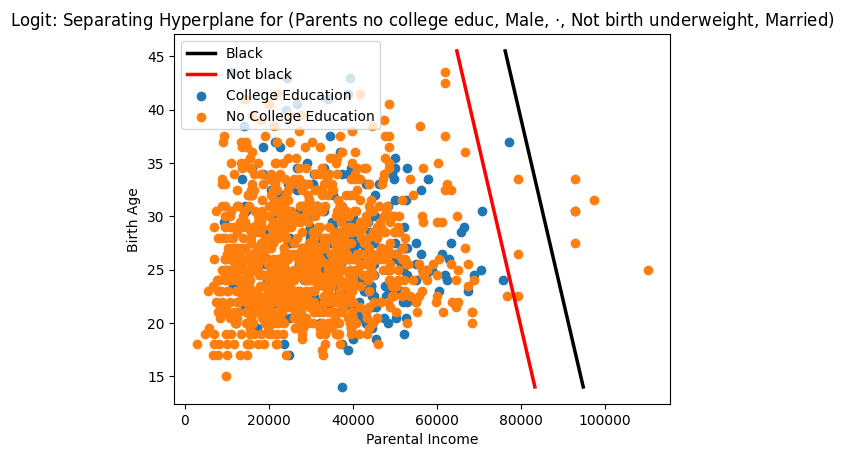

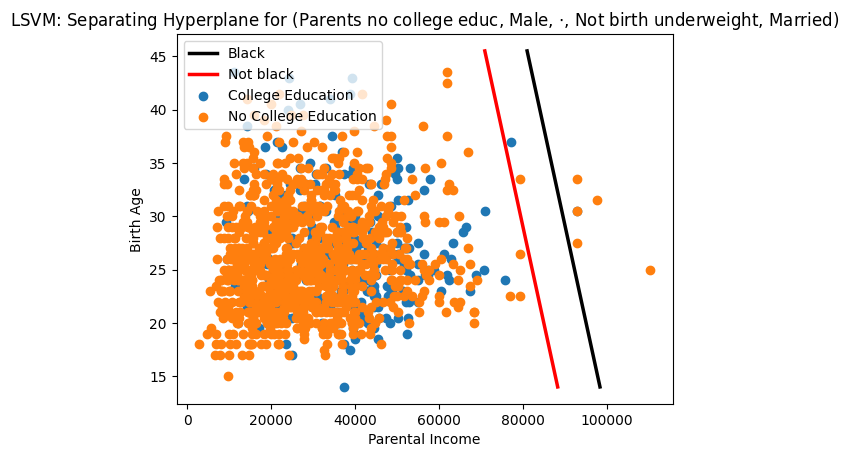

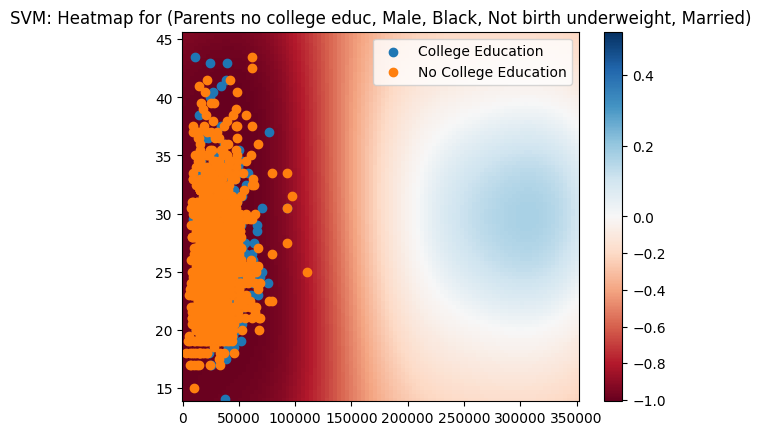

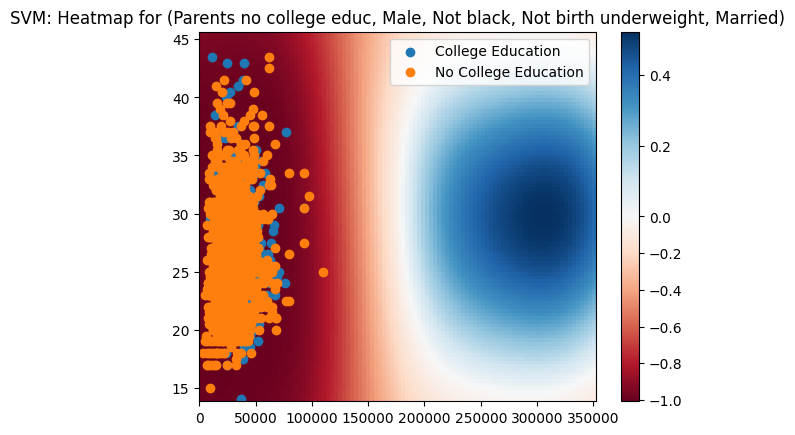

In [13]:

plt.plot(prt_inc_grid_logit_1*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='black',label='Black')
plt.plot(prt_inc_grid_logit_0*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='red',label='Not black')
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.legend()
plt.title('Logit: Separating Hyperplane for (Parents no college educ, Male, $\cdot$, Not birth underweight, Married)')
plt.ylabel('Birth Age')
plt.xlabel('Parental Income')
plt.show()

plt.plot(prt_inc_grid_LSVM_1*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='black',label='Black')
plt.plot(prt_inc_grid_LSVM_0*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='red',label='Not black')
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.legend()
plt.title('LSVM: Separating Hyperplane for (Parents no college educ, Male, $\cdot$, Not birth underweight, Married)')
plt.ylabel('Birth Age')
plt.xlabel('Parental Income')
plt.show()

norm = colors.TwoSlopeNorm(vcenter=0,vmin=np.min((f_hat_grid_0,f_hat_grid_1)),  vmax=np.max((f_hat_grid_0,f_hat_grid_1)))
c = plt.pcolormesh(prt_inc_grid*X_used_std.prt_inc+X_used_mean.prt_inc,
                   birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,f_hat_grid_1.T, cmap='RdBu',norm=norm)
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.colorbar(c)
plt.legend()
plt.title('SVM: Heatmap for (Parents no college educ, Male, Black, Not birth underweight, Married)')
plt.show()

norm = colors.TwoSlopeNorm(vcenter=0,vmin=np.min((f_hat_grid_0,f_hat_grid_1)),  vmax=np.max((f_hat_grid_0,f_hat_grid_1)))
c = plt.pcolormesh(prt_inc_grid*X_used_std.prt_inc+X_used_mean.prt_inc,
                   birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,f_hat_grid_0.T, cmap='RdBu',norm=norm)
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.title('SVM: Heatmap for (Parents no college educ, Male, Not black, Not birth underweight, Married)')
plt.colorbar(c)
plt.legend()
plt.show()

In [14]:
#################################
##### Effect of being female #####
#################################
group_id_1 = {'parent_edu_college':0, 'person_sex':1, 'black':0, 'birth_underweight':0,
           'never_married':0, 'widowed':0, 'divorced':0, 'separated':0}
group_val_1 = {}

group_id_0 = {'parent_edu_college':0, 'person_sex':0, 'black':0, 'birth_underweight':0,
           'never_married':0, 'widowed':0, 'divorced':0, 'separated':0}
group_val_0 = {}

for key, value in group_id_1.items():
    group_val_1[key] = dummies_stzd.loc[key][value]

for key, value in group_id_0.items():
    group_val_0[key] = dummies_stzd.loc[key][value]

prt_inc_grid_logit_1 = (-Logit_model.intercept_[0]-Logit_model.coef_[0][1]*birth_age_grid
                      -Logit_model.coef_[0][2:] @ np.array(list(group_val_1.values())))/Logit_model.coef_[0][0]
prt_inc_grid_logit_0 = (-Logit_model.intercept_[0]-Logit_model.coef_[0][1]*birth_age_grid
                      -Logit_model.coef_[0][2:] @ np.array(list(group_val_0.values())))/Logit_model.coef_[0][0]

prt_inc_grid_LSVM_1 = (-LSVM_model.intercept_[0]-LSVM_model.coef_[0][1]*birth_age_grid
                      -LSVM_model.coef_[0][2:] @ np.array(list(group_val_1.values())))/LSVM_model.coef_[0][0]
prt_inc_grid_LSVM_0 = (-LSVM_model.intercept_[0]-LSVM_model.coef_[0][1]*birth_age_grid
                      -LSVM_model.coef_[0][2:] @ np.array(list(group_val_0.values())))/LSVM_model.coef_[0][0]

grid_n = prt_inc_grid.shape[0]
xx11, xx22 = np.meshgrid(birth_age_grid, prt_inc_grid)

X_grid_1 = np.concatenate([xx22.ravel().reshape(-1,1),                                                        # Parental Income grid
                         xx11.ravel().reshape(-1,1),                                                        # Birth age grid
                         (np.array(list(group_val_1.values()))*np.ones((grid_n**2,1)))], axis=1)            # not separated
X_grid_0 = np.concatenate([xx22.ravel().reshape(-1,1),                                                        # Parental Income grid
                         xx11.ravel().reshape(-1,1),                                                        # Birth age grid
                         (np.array(list(group_val_0.values()))*np.ones((grid_n**2,1)))], axis=1)            # not separated

X_grid_1 = pd.DataFrame(X_grid_1)
X_grid_1.columns = X_used.columns
f_hat_vec_1 = SVM_model.decision_function(X_grid_1)
f_hat_grid_1 = f_hat_vec_1.reshape(grid_n,grid_n)

X_grid_0 = pd.DataFrame(X_grid_0)
X_grid_0.columns = X_used.columns
f_hat_vec_0 = SVM_model.decision_function(X_grid_0)
f_hat_grid_0 = f_hat_vec_0.reshape(grid_n,grid_n)

query = ""
for key, value in group_id_1.items():
    if value == group_id_0[key]:
        query = query + key + '==' + str(value) +' and '
query = query[:-5]
X_temp = X_used.query(query)
Y_temp_used = Y_used[X_temp.index]

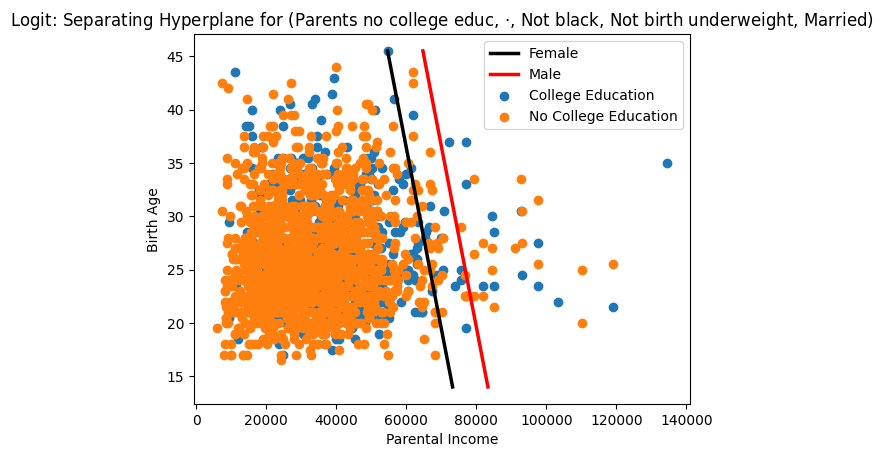

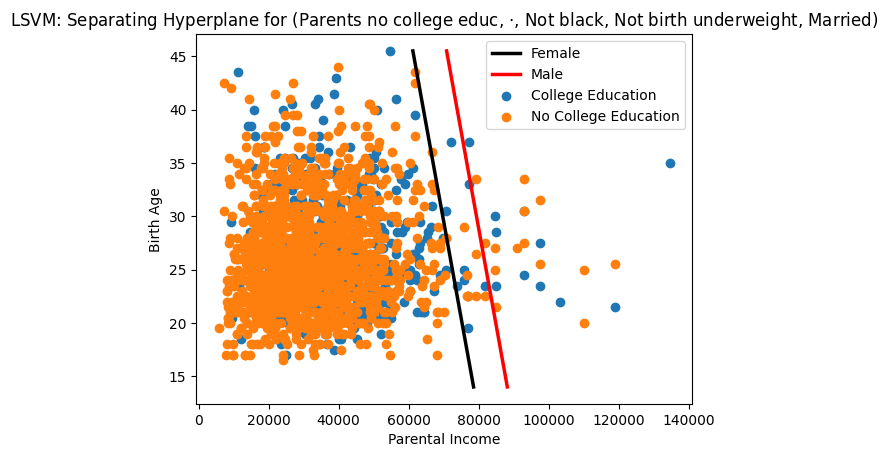

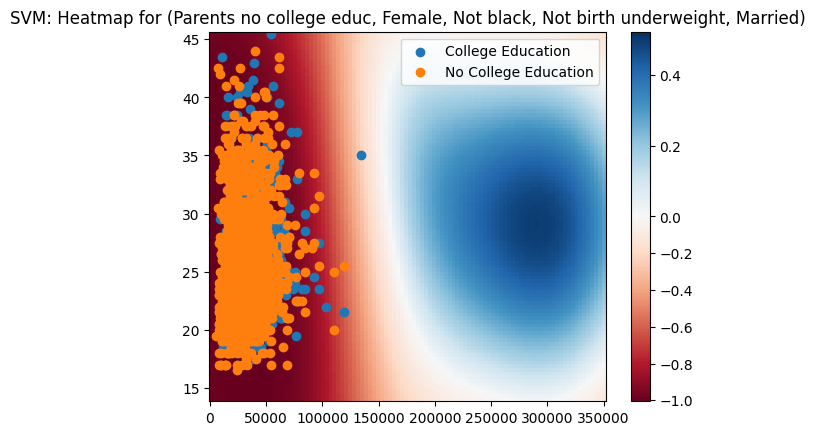

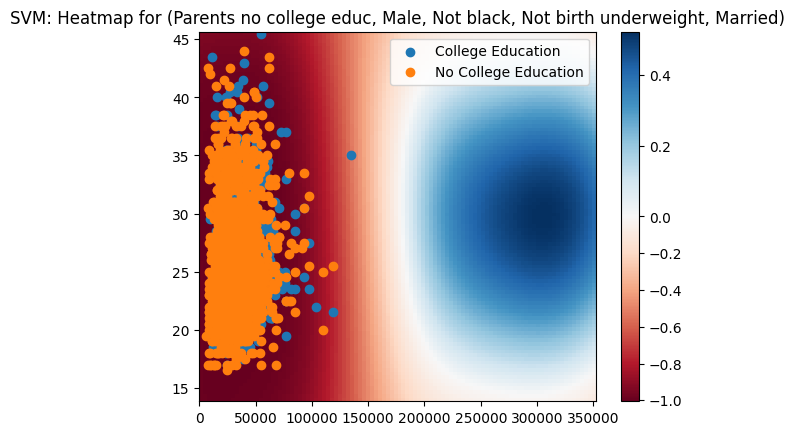

In [15]:

plt.plot(prt_inc_grid_logit_1*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='black',label='Female')
plt.plot(prt_inc_grid_logit_0*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='red',label='Male')
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.legend()
plt.title('Logit: Separating Hyperplane for (Parents no college educ, $\cdot$, Not black, Not birth underweight, Married)')
plt.ylabel('Birth Age')
plt.xlabel('Parental Income')
plt.show()

plt.plot(prt_inc_grid_LSVM_1*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='black',label='Female')
plt.plot(prt_inc_grid_LSVM_0*X_used_std.prt_inc+X_used_mean.prt_inc,
         birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,linewidth=2.5,color='red',label='Male')
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.legend()
plt.title('LSVM: Separating Hyperplane for (Parents no college educ, $\cdot$, Not black, Not birth underweight, Married)')
plt.ylabel('Birth Age')
plt.xlabel('Parental Income')
plt.show()

norm = colors.TwoSlopeNorm(vcenter=0,vmin=np.min((f_hat_grid_0,f_hat_grid_1)),  vmax=np.max((f_hat_grid_0,f_hat_grid_1)))
c = plt.pcolormesh(prt_inc_grid*X_used_std.prt_inc+X_used_mean.prt_inc,
                   birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,f_hat_grid_1.T, cmap='RdBu',norm=norm)
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.colorbar(c)
plt.legend()
plt.title('SVM: Heatmap for (Parents no college educ, Female, Not black, Not birth underweight, Married)')
plt.show()

norm = colors.TwoSlopeNorm(vcenter=0,vmin=np.min((f_hat_grid_0,f_hat_grid_1)),  vmax=np.max((f_hat_grid_0,f_hat_grid_1)))
c = plt.pcolormesh(prt_inc_grid*X_used_std.prt_inc+X_used_mean.prt_inc,
                   birth_age_grid*X_used_std.birth_age+X_used_mean.birth_age,f_hat_grid_0.T, cmap='RdBu',norm=norm)
plt.scatter(X_temp.prt_inc[Y_temp_used==1],X_temp.birth_age[Y_temp_used==1],label="College Education")
plt.scatter(X_temp.prt_inc[Y_temp_used==0],X_temp.birth_age[Y_temp_used==0],label="No College Education")
plt.title('SVM: Heatmap for (Parents no college educ, Male, Not black, Not birth underweight, Married)')
plt.colorbar(c)
plt.legend()
plt.show()